In [ ]:
# Para cargar lo necesario
import pickle
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

from qiskit.circuit.library import TwoLocal
from qiskit.circuit import QuantumCircuit

from qiskit.circuit.library import NLocal, CCXGate, CRZGate, RXGate, XGate
from qiskit.circuit import Parameter

# Agrega el path al directorio raíz del proyecto
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../")))
import customFunctions as cf

In [14]:
# Ansatz

def crear_ansatz_NLocal(num_qubits):
    theta = Parameter("θ")
    ansatz = NLocal(
        num_qubits = num_qubits,
        rotation_blocks=[RXGate(theta), CRZGate(theta)],  # Keep rotation blocks
        entanglement_blocks=CCXGate(),
        entanglement=[[0, 1, 2], [1, 2, 3]],  # Define entanglement pattern
        reps=2,
        insert_barriers=True,
    )
    
    return ansatz, ansatz.num_parameters

[-0.30549211821090827, -0.916865900994474, -1.088539972316644, -1.131619863788285, -1.112129295673468, -1.0796298119923384, -1.0424369271398826, -1.0036803728288999, -0.9714471019256861, -0.9069581487173616, -0.917228676119421, -0.9325733502384284, -0.9286349503772614, -0.929865911891391, -0.9294458368128136, -0.9311682410878304, -0.9324155502507154, -0.9325518022730073, -0.9326334775047115, -0.9333606209873537, -0.9322044104398521, -0.9329068136028622, -0.9329302132158035, -0.9329361560240672, -0.9320527851516628]


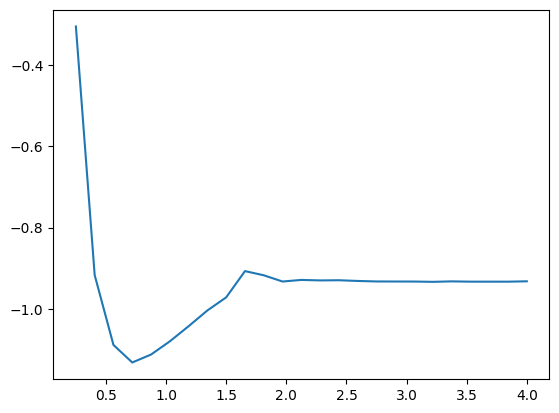

In [ ]:
# Cargamos los hamiltonianos y las energías de repulsión y aplicamos el VQE

distances = np.linspace(0.25, 4, 25)
total_energies = []

for dist in distances:
    # Hamiltonianos
    with open(f"data/hamiltonian{dist:.3f}.pkl", "rb") as f:
        hamiltonian = pickle.load(f)
    # Energías de repulsión
    with open(f"data/nuclear_repulsion{dist:.3f}.pkl", "rb") as f:
        nuclear_repulsion = pickle.load(f)

    total_energies.append(cf.VQE_minimization_BP(crear_ansatz_NLocal, 4, 4, hamiltonian, [], print_info=False, plot_info=False)["minimum_values"][0] + nuclear_repulsion)

plt.plot(distances, total_energies)

Iteración 1: Energía = -1.0827036645785073
Iteración 2: Energía = -1.2388974967560624
Iteración 3: Energía = -1.1013376252976224
Iteración 4: Energía = -1.2643249798217988
Iteración 5: Energía = -1.0884930286078218
Iteración 6: Energía = -1.2083522126593813
Iteración 7: Energía = -1.3254772879853143
Iteración 8: Energía = -1.4133915009414446
Iteración 9: Energía = -1.2056311314106327
Iteración 10: Energía = -1.4923928159163482
Iteración 11: Energía = -1.1613650099322286
Iteración 12: Energía = -1.5011853583214767
Iteración 13: Energía = -1.5007354496294387
Iteración 14: Energía = -1.5275308524966011
Iteración 15: Energía = -1.2073511728122968
Iteración 16: Energía = -1.468090972705667
Iteración 17: Energía = -1.2418129556472601
Iteración 18: Energía = -1.5258841846318807
Iteración 19: Energía = -1.5319552240006629
Iteración 20: Energía = -1.66310993180073
Iteración 21: Energía = -1.7365511349543357
Iteración 22: Energía = -1.790107020817335
Iteración 23: Energía = -1.7125988516838266
I

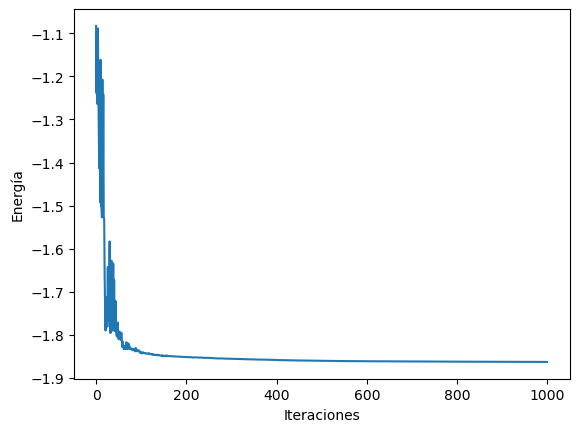

In [4]:
# Simulador local
simulator = Aer.get_backend('qasm_simulator')

# Ansatz de 4 qubits
theta = Parameter("θ")
ansatz = NLocal(
    num_qubits=4,
    rotation_blocks=[RXGate(theta), CRZGate(theta)],  # Keep rotation blocks
    entanglement_blocks=CCXGate(),
    entanglement=[[0, 1, 2], [1, 2, 3]],  # Define entanglement pattern
    reps=2,
    insert_barriers=True,
)

num_params = ansatz.num_parameters

# Inicialización del parámetro
x0 = 2 * np.pi * np.random.random(num_params)

# Diccionario para almacenar la evolución del costo
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

# Función de coste
def cost_func(params, ansatz, hamiltonian, estimator):
    job = estimator.run([ansatz], [hamiltonian], [params])
    result = job.result()
    energy = result.values[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)

    print(f"Iteración {cost_history_dict['iters']}: Energía = {energy}")

    return energy

# Creamos el estimador para el simulador
backend=simulator
estimator = Estimator()

# Ejecutamos la optimización
res = minimize(
    cost_func,
    x0,
    args=(ansatz, hamiltonian, estimator),
    method="COBYLA",
)

# Resultado final
print("Parámetros óptimos:", res.x)
print("Energía mínima encontrada:", res.fun)

# Graficar evolución del costo
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iteraciones")
ax.set_ylabel("Energía")
plt.show()

In [5]:
# Energía total

energy = res.fun + nuclear_repulsion
print(f"Energía total: {energy}")

Energía total: -1.1332059209051424


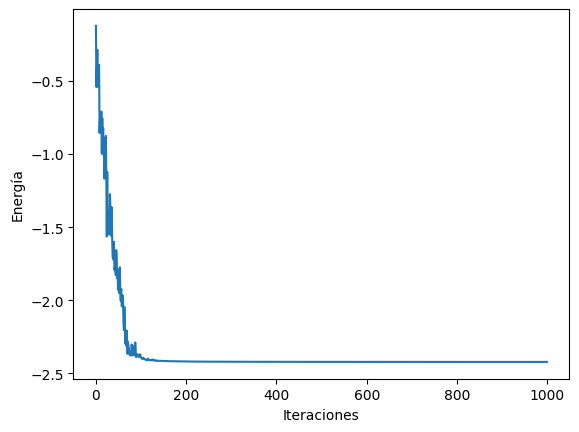

Energía en 0.250 Å: -0.304958 Ha


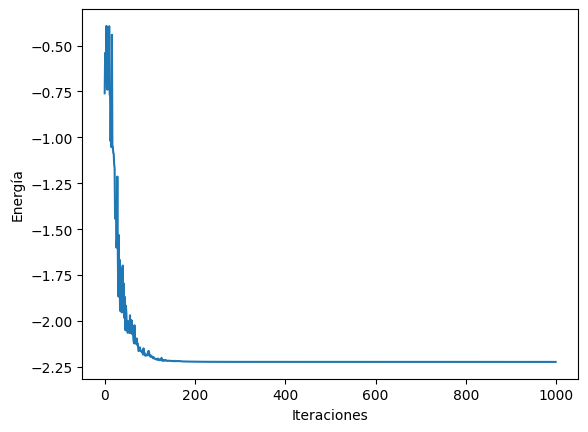

Energía en 0.406 Å: -0.920861 Ha


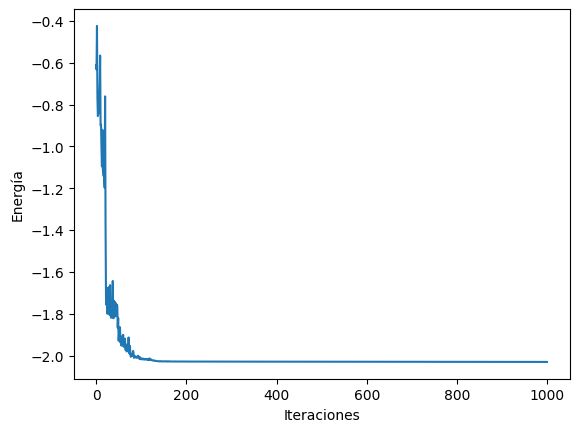

Energía en 0.562 Å: -1.089716 Ha


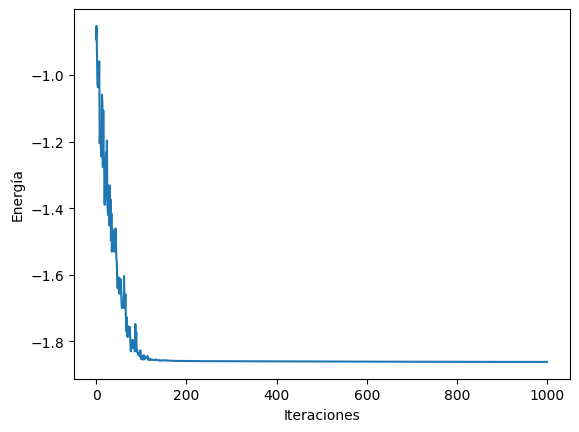

Energía en 0.719 Å: -1.125394 Ha


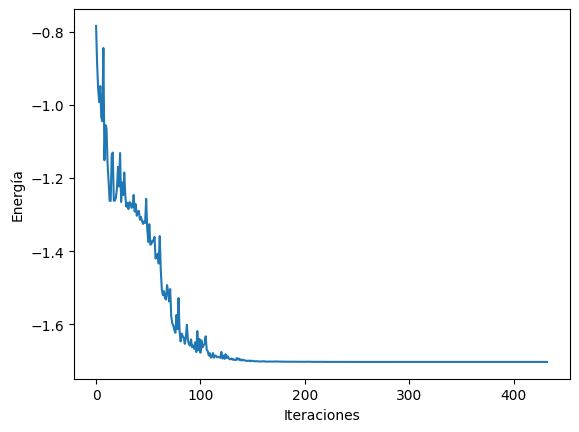

Energía en 0.875 Å: -1.097454 Ha


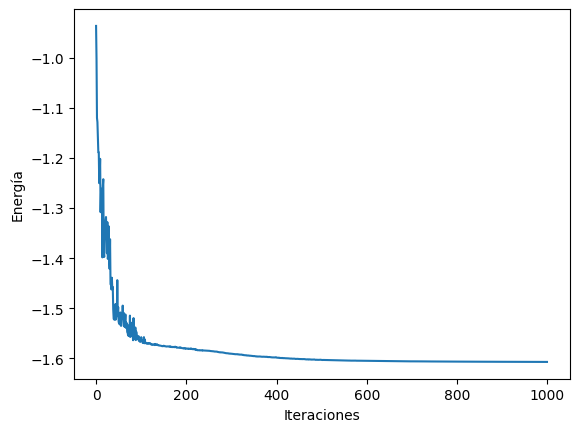

Energía en 1.031 Å: -1.093872 Ha


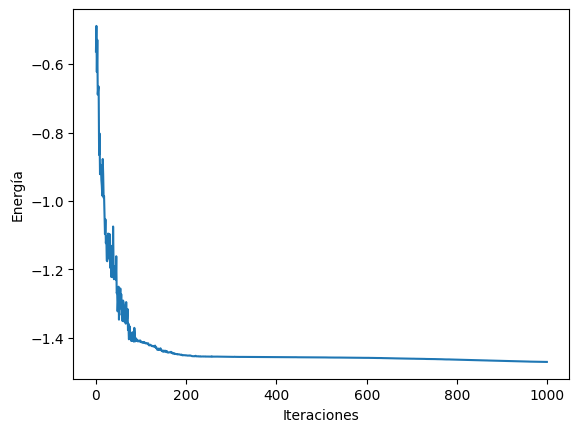

Energía en 1.188 Å: -1.024356 Ha


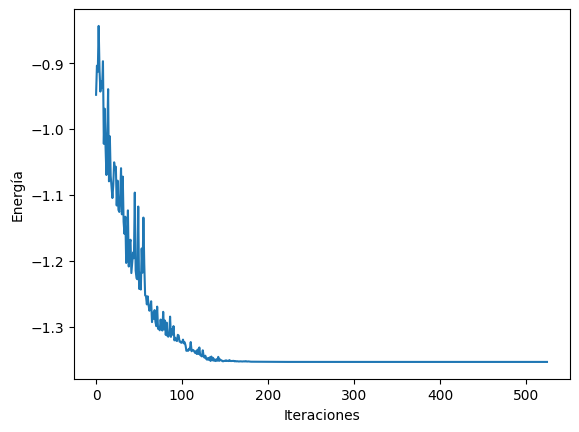

Energía en 1.344 Å: -0.959183 Ha


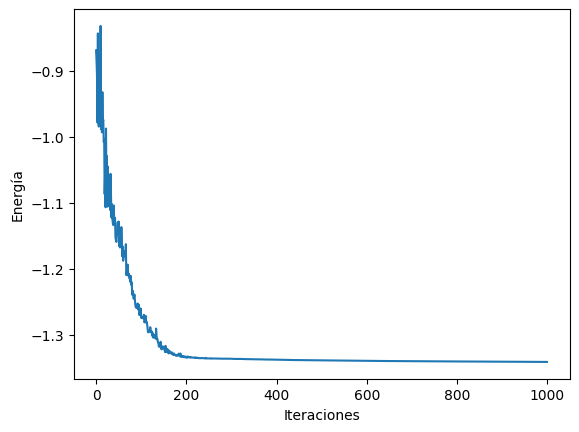

Energía en 1.500 Å: -0.988153 Ha


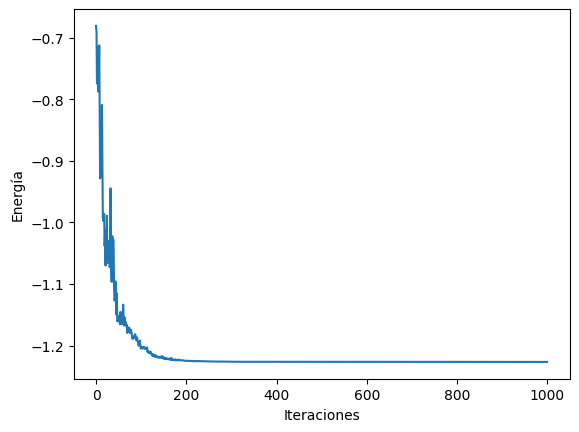

Energía en 1.656 Å: -0.906948 Ha


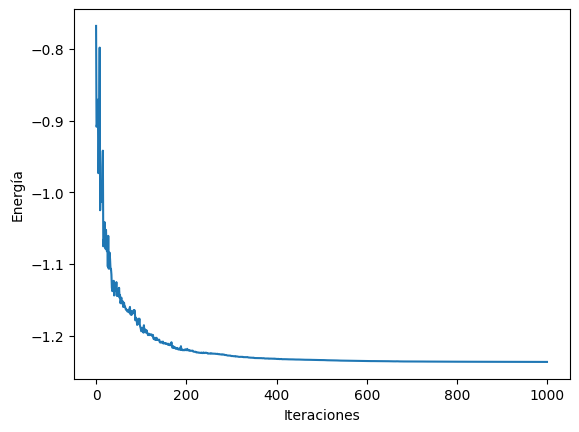

Energía en 1.812 Å: -0.944659 Ha


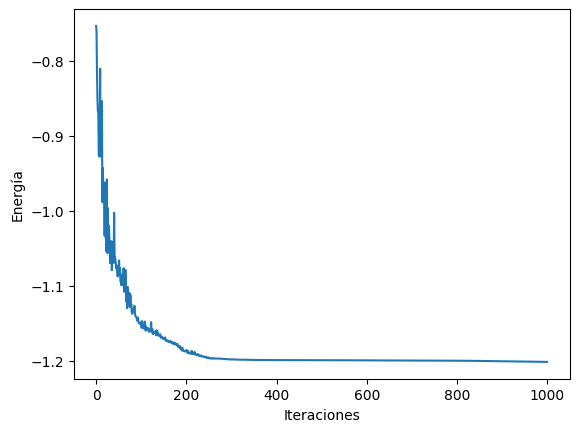

Energía en 1.969 Å: -0.932658 Ha


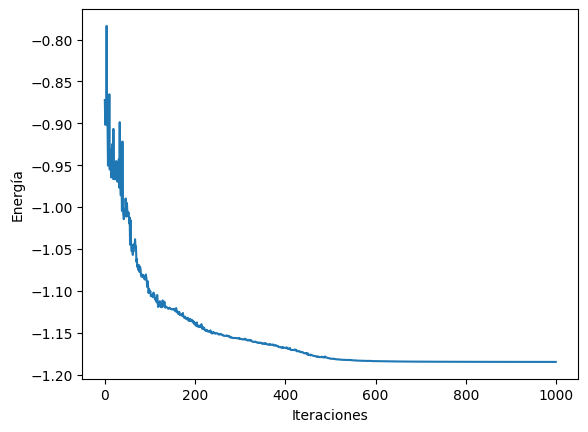

Energía en 2.125 Å: -0.935942 Ha


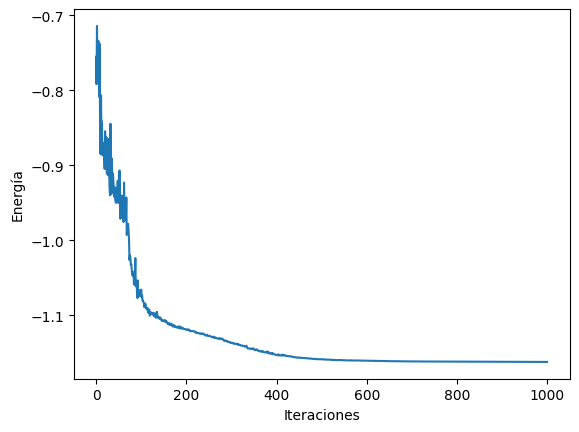

Energía en 2.281 Å: -0.930102 Ha


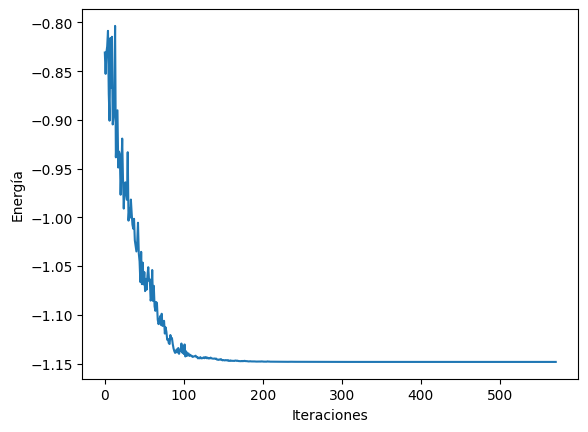

Energía en 2.438 Å: -0.931254 Ha


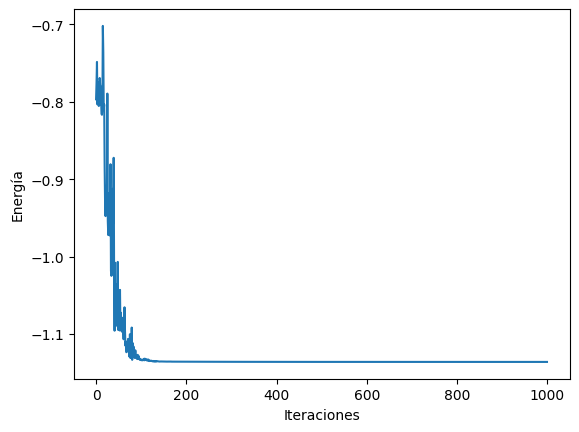

Energía en 2.594 Å: -0.932074 Ha


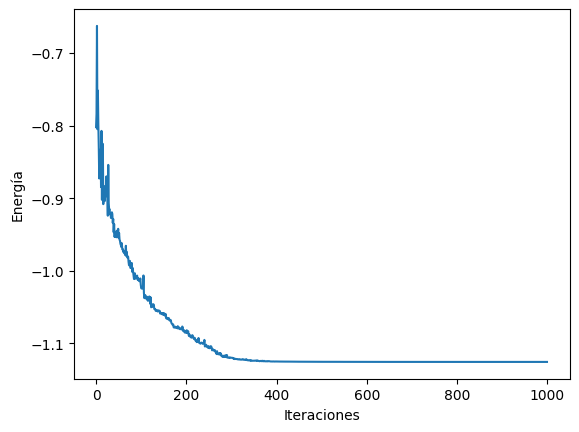

Energía en 2.750 Å: -0.933169 Ha


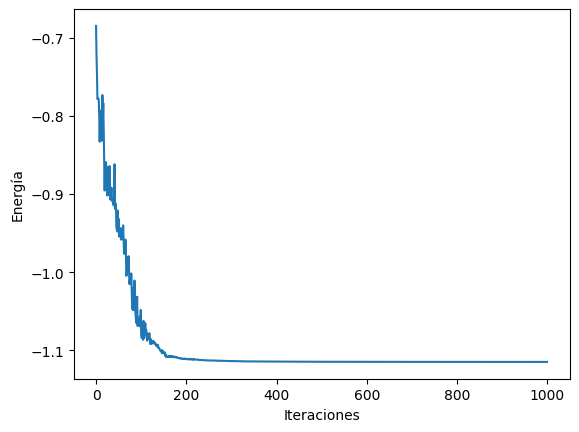

Energía en 2.906 Å: -0.932809 Ha


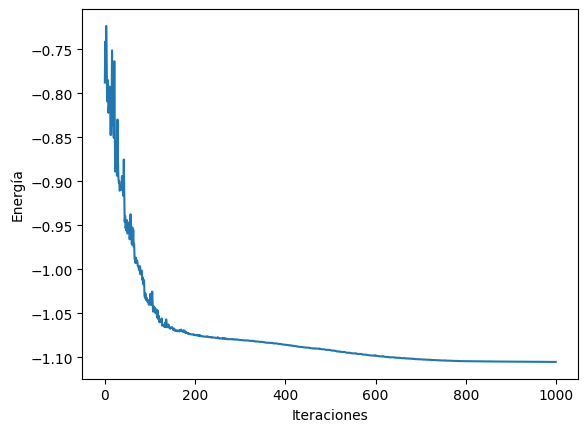

Energía en 3.062 Å: -0.932387 Ha


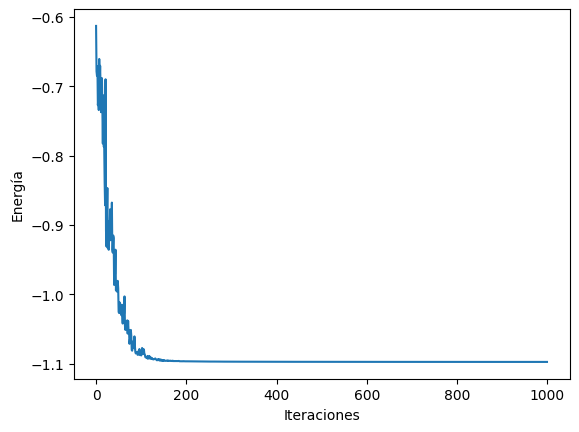

Energía en 3.219 Å: -0.933033 Ha


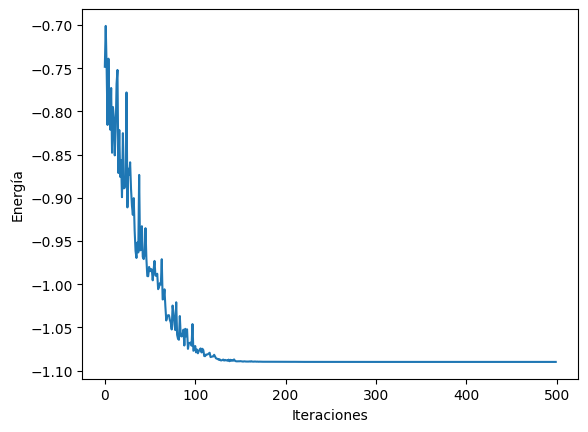

Energía en 3.375 Å: -0.933116 Ha


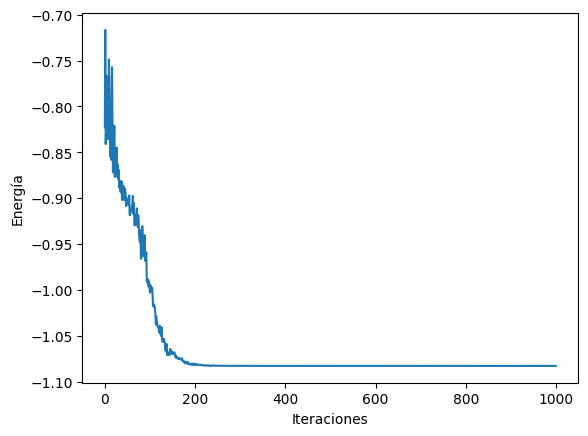

Energía en 3.531 Å: -0.933138 Ha


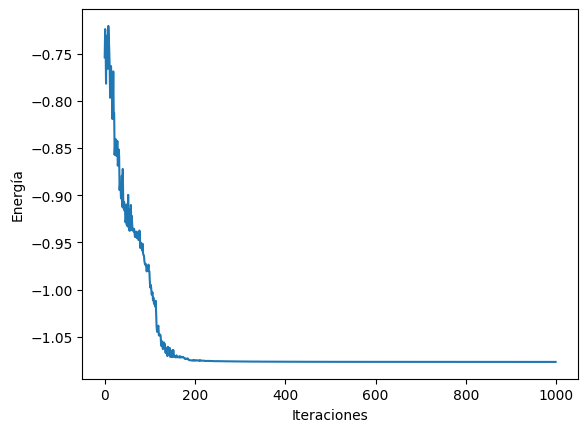

Energía en 3.688 Å: -0.933147 Ha


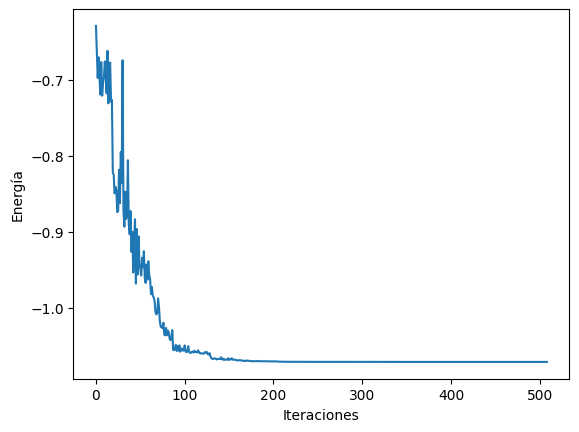

Energía en 3.844 Å: -0.933158 Ha


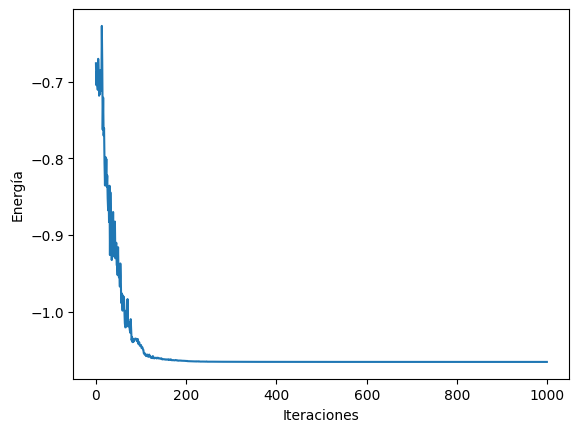

Energía en 4.000 Å: -0.933151 Ha


In [8]:
# Range of distances in Angstroms
distances = np.linspace(0.25, 4, 25)
energies = []

for dist in distances:
    # Cargar el hamiltoniano desde el archivo
    with open(f"data/hamiltonian{dist:.3f}.pkl", "rb") as f:
        hamiltonian = pickle.load(f)

    # Define ansatz
    theta = Parameter("θ")
    ansatz = NLocal(
        num_qubits=4,
        rotation_blocks=[RXGate(theta), CRZGate(theta)],
        entanglement_blocks=CCXGate(),
        entanglement=[[0, 1, 2], [1, 2, 3]],
        reps=2,
        insert_barriers=True,
    )
    for qubit in [0, 2]:
        ansatz.add_layer(XGate(), [qubit])

    num_params = ansatz.num_parameters
    x0 = 2 * np.pi * np.random.random(num_params)

    # Reset cost tracking
    cost_history_dict = {"prev_vector": None, "iters": 0, "cost_history": []}

    # Cost function
    def cost_func(params, ansatz, hamiltonian, estimator):
        job = estimator.run([ansatz], [hamiltonian], [params])
        result = job.result()
        energy = result.values[0]
        cost_history_dict["iters"] += 1
        cost_history_dict["prev_vector"] = params
        cost_history_dict["cost_history"].append(energy)
        return energy

    # Estimator
    estimator = Estimator()

    # Optimize
    res = minimize(
        cost_func,
        x0,
        args=(ansatz, hamiltonian, estimator),
        method="COBYLA",
    )

    # Graficar evolución del costo
    fig, ax = plt.subplots()
    ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
    ax.set_xlabel("Iteraciones")
    ax.set_ylabel("Energía")
    plt.show()

    # Cargar nuclear_repulsion desde el archivo
    with open(f"data/nuclear_repulsion{dist:.3f}.pkl", "rb") as f:
        nuclear_repulsion = pickle.load(f)
    
    # Total energy (electronic + nuclear repulsion)
    total_energy = res.fun + nuclear_repulsion
    energies.append(total_energy)

    print(f"Energía en {dist:.3f} Å: {total_energy:.6f} Ha")